# LSTM Text Generation 2: Word Embedding

# 1. Introduction

In the TextGen2 notebook, I explored the first improved neural network which used word Embedding to represent word, this allows me to process a larger vocabulary pool, as well as longer lookback length. Both help the network to be capable of dealing with a larger database.

In this notebook, I try to extend the study from one novel to 3 novels. The word size increases by a factor of 4. And the vocabulary size also multiplied by 4. I want to explore how the larger corpus size helps the network to recognize more pattern for text generation.

I will continue to explore the Children's Literature by Andrew Lang as children's literature has a relatively smaller vocabulary size and simpler sentence structure, and yet the content can be very diversified with words and concepts not commonly found in other literature (e.g. Newspaper) such as prince, magic, witch and so on. The corpus is obtained from the open-source Gutenburg project. 

Written by Shing Chi Leung at 1 February 2021.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount("gdrive")

Mounted at gdrive


In [34]:
filePath = "gdrive/MyDrive/Colab Notebooks/story_corpus_1-3.txt"

def read_data(filePath):

  titles = []
  authors = []

  full_word_tokens = []
  full_sent_tokens = []

  with open(filePath, "r") as f:
    for line in f.readlines():

            if "_BOOK_TITLE_" in line:
                # extra book title and author from meta
                meta = (line.strip().split(" ")[2]).split("__")
                author = meta[0]
                title = meta[1].replace("_"," ").strip()

                # add file to catalogue
                authors.append(author)
                titles.append(title)
            
                print("Reading file {} by {}".format(title, author))

            elif "CHAPTER" in line:
                #print("Reading chapter line")
                pass

            else:

                # save the whole lines as a sentence token
                sent = line.strip().split(" ")
                for i in range(len(sent)):
                  sent[i] = sent[i].lower()
                full_sent_tokens.append(sent)

                # split the sentence into words, and save
                # the filtered words and full words into two lists
                for word in line.strip().split(" "):
                    full_word_tokens.append(word.lower())

    return full_sent_tokens, full_word_tokens

sent_tokens, word_tokens = read_data(filePath)
print("First 3 sentences: {}".format(sent_tokens[:3]))
print("First 15 words: {}".format(word_tokens[:15]))

Reading file Prince Prigio.txt.out by Andrew_Lang
Reading file Prince Prigio From "His Own Fairy Book".txt.out by Andrew_Lang
Reading file Prince Ricardo of Pantouflia.txt.out by Andrew_Lang
First 3 sentences: [['once', 'upon', 'a', 'time', 'there', 'reigned', 'in', 'pantouflia', 'a', 'king', 'and', 'a', 'queen', '.'], ['with', 'almost', 'everything', 'else', 'to', 'make', 'them', 'happy', ',', 'they', 'wanted', 'one', 'thing', ':', 'they', 'had', 'no', 'children', '.'], ['this', 'vexed', 'the', 'king', 'even', 'more', 'than', 'the', 'queen', ',', 'who', 'was', 'very', 'clever', 'and', 'learned', ',', 'and', 'who', 'had', 'hated', 'dolls', 'when', 'she', 'was', 'a', 'child', '.']]
First 15 words: ['once', 'upon', 'a', 'time', 'there', 'reigned', 'in', 'pantouflia', 'a', 'king', 'and', 'a', 'queen', '.', 'with']


To assist me to choose the appropriate network size, it is educational to output some statistics about the text. 

In [35]:
num_sents = len(sent_tokens)
num_words = len(word_tokens)

num_vocab = len(set([word for word in word_tokens if word.isalpha()]))

word_freq = nltk.FreqDist([word for word in word_tokens if (word.isalpha() and len(word)>=5)])
most_freq_words = word_freq.most_common(40)

print("Principle analysis of the text:")
print("Number of sentences: {}".format(num_sents))
print("Number of words: {}".format(num_words))
print("Number of vocab: {}".format(num_vocab))
print("Most frequent words (len>=5): {}".format(most_freq_words[:10]))

Principle analysis of the text:
Number of sentences: 3363
Number of words: 71338
Number of vocab: 4319
Most frequent words (len>=5): [('prince', 534), ('there', 234), ('prigio', 227), ('which', 221), ('would', 177), ('firedrake', 164), ('about', 162), ('could', 151), ('never', 140), ('where', 126)]


# 2. Building Dictionary for Word Index and Train/Test Data Set

I also need to build the word_dict so that I can use the sparse_categorical crossentropy functionality in the Keras module, which will alleviate the large storage demand compared to one-hot vector (see TextGen1). 

This time I will pass the sentence to GenSim for the word embedding instead of building my own word_dict and word embedding.

In [42]:
embedding_size = 50

word_embed = Word2Vec(sent_tokens, min_count=1, window=5, workers=4, size=embedding_size, iter=100, sg=1)

pretrained_weights = word_embed.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape

print(word_embed)
print("prince has a embedding vector: {}\n".format(word_embed["prince"]))

# obtained from stack overflow for testing the word_embed 
# https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation

print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['prince', 'king', 'prigio', 'firedrake']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) 
                           for similar, dist in word_embed.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))



Word2Vec(vocab=4582, size=50, alpha=0.025)
prince has a embedding vector: [ 0.03779069 -0.06951673  0.05832599 -0.22486241 -0.00535076  0.24408363
  0.3825679   0.4619627  -0.61605686 -0.06793546 -0.29686832 -0.251666
 -0.49850434  0.13949695  0.13220489  0.3142334  -0.08605368  0.6617788
 -0.56741583  0.56607956  0.13393967  0.19057664  0.5421996   0.20086974
 -0.08934341 -0.23202093 -0.40091968 -0.22030948  0.07840814  0.12067549
 -0.0575025   0.24480285 -0.31193808 -0.45834383  0.30596873 -0.33296803
  0.58295    -0.42786166 -0.14656162  0.59758586 -0.08757815  0.7155215
  0.88263327  0.02400188 -0.07893524  0.33704135 -0.07601715  0.30858758
  0.37903634 -0.12076633]

Result embedding shape: (4582, 50)
Checking similar words:
  prince -> king (0.74), prigio (0.67), charles (0.64), p15.jpg (0.64), p129.jpg (0.61), desk (0.61), meanwhile (0.59), , (0.59)
  king -> prince (0.74), queen (0.65), james (0.59), prigio (0.58), she (0.57), conspire (0.57), ambassador (0.56), shedding (0.56)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


Different from previous version, the vocab size from word embedding determines the max vocab I should build in the dictionary. 

In [43]:
max_vocab = vocab_size
UDW_token = 0

def build_word_dict(word_tokens, max_vocab):

  word_dict = {"UDW":UDW_token}
  inv_word_dict = {UDW_token:"UDW"}

  word_id = 1

  for word in word_tokens:

    if len(word_dict) >= max_vocab:
      print("word quota filled")
      break

    if word not in word_dict:
      word_dict[word] = word_id
      word_id += 1

  # then build the inverse library
  for k, v in word_dict.items():
    inv_word_dict[v] = k
 
  return word_dict, inv_word_dict

word_dict, inv_word_dict = build_word_dict(word_tokens, max_vocab)
print("ID for 'prince' in word_dict is {}".format(word_dict["prince"]))
print("The ID {} in inv_word_dict corrsponds to {}".format(word_dict["prince"], 
                                                           inv_word_dict[word_dict["prince"]]))

word quota filled
ID for 'prince' in word_dict is 63
The ID 63 in inv_word_dict corrsponds to prince


Then we can use the word embedding to understand the relations among words. To do so, we use the Principle Component Analysis option in sklearn. This will project the high dimensional vector into 2-dimension, which is understandable by human eyes. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


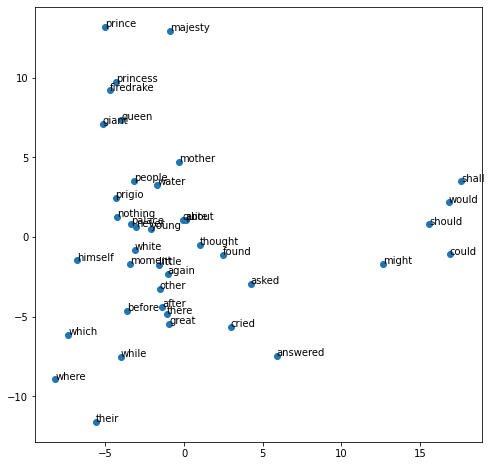

In [ ]:
X = [word_embed[word[0]] for word in most_freq_words]

pca = PCA(n_components=2)
analysis = pca.fit_transform(X)

fig = plt.figure(figsize=(8,8))
ax = plt.scatter(analysis[:,0], analysis[:,1])
words = list(most_freq_words)
for i, word in enumerate(words):
  if i > 70: break
  plt.annotate(word[0], xy=(analysis[i,0], analysis[i,1]))

With the vector formalism, it becomes much easier for us to analyze the word pattern with more information during the training. We observe that there are a few clusters. The left cluster corresponds to word for specific nouns appeared in the story, such as firedrake, queen, Jaqueline (the queen), prince and so on. On the bottom there are common verbs such as cried, answered on one side, and prepositional word like which, while, where on the other side.

In [44]:
lookback = 10
test_ratio = 0.05

def get_word_id(word, word_dict):
  if word in word_dict:
    return word_dict[word]
  else:
    return word_dict["UDW"]

def make_train_test_set(word_tokens, word_dict, lookback, test_ratio):

  full_source_array = []
  full_target_array = []
  for i in range(len(word_tokens)-lookback):

    source_array = []
    for j in range(lookback):
      vec = get_word_id(word_tokens[i+j], word_dict)
      source_array.append(vec)
    full_source_array.append(source_array)

    vec = get_word_id(word_tokens[i+lookback], word_dict)
    full_target_array.append(vec)

  x_train, x_test, y_train, y_test = train_test_split(
      full_source_array, full_target_array, test_size=test_ratio, shuffle=True)



  # change the list array to np.array
  x_train = np.array(x_train)
  x_test = np.array(x_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  # reshape x_train and y_train for LSTM purpose
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

  return x_train, x_test, y_train, y_test

#print(get_word_embed("prince", word_embed))

x_train, x_test, y_train, y_test = make_train_test_set(word_tokens, word_dict, lookback, test_ratio)
print("x_train has a shape: {}".format(x_train.shape))
print("x_test has a shape: {}".format(x_test.shape))

x_train has a shape: (67761, 10, 1)
x_test has a shape: (3567, 10, 1)


# 3. Building the LSTM Neural Network with Word Embedding

Now the training and testing dataset is ready. I will build the LSTM network with the embedding layer inherited from Word2Vec. This allows the network to directly translate the word_index to a lower-dimensional vector for computation. 

In [45]:
def build_model():

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=lookback, output_dim=embedding_size, weights=[pretrained_weights], trainable=False))
  model.add(LSTM(80))
  model.add(Dropout(0.1))
  #model.add(LSTM(80))
  #model.add(Dropout(0.1))
  #model.add(LSTM(50))
  #model.add(Dropout(0.1))
  model.add(Dense(vocab_size, activation="softmax"))
  return model

model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 10, 50)            229100    
_________________________________________________________________
lstm_10 (LSTM)               (None, 80)                41920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4582)              371142    
Total params: 642,162
Trainable params: 413,062
Non-trainable params: 229,100
_________________________________________________________________


In [46]:
def compile_model(model):
  optimizer="adam"
  loss="sparse_categorical_crossentropy"
  metrics=["accuracy"]
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

compile_model(model)

In [50]:
def train_model(model, x_train, y_train):
  history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.05)
  return history

history = train_model(model, x_train, y_train) 

Epoch 1/10
2012/2012 [==============================] - 28s 14ms/step - loss: 2.3755 - accuracy: 0.4520 - val_loss: 4.5383 - val_accuracy: 0.2785
Epoch 2/10
2012/2012 [==============================] - 27s 14ms/step - loss: 2.3544 - accuracy: 0.4544 - val_loss: 4.5435 - val_accuracy: 0.2803
Epoch 3/10
2012/2012 [==============================] - 27s 13ms/step - loss: 2.3260 - accuracy: 0.4590 - val_loss: 4.5415 - val_accuracy: 0.2830
Epoch 4/10
2012/2012 [==============================] - 28s 14ms/step - loss: 2.3023 - accuracy: 0.4665 - val_loss: 4.5513 - val_accuracy: 0.2780
Epoch 5/10
2012/2012 [==============================] - 28s 14ms/step - loss: 2.2826 - accuracy: 0.4689 - val_loss: 4.5551 - val_accuracy: 0.2833
Epoch 6/10
2012/2012 [==============================] - 28s 14ms/step - loss: 2.2602 - accuracy: 0.4723 - val_loss: 4.5546 - val_accuracy: 0.2859
Epoch 7/10
2012/2012 [==============================] - 28s 14ms/step - loss: 2.2434 - accuracy: 0.4742 - val_loss: 4.5693 -

In [ ]:
result = model.evaluate(x_test, y_test)

112/112 [==============================] - 1s 7ms/step - loss: 4.3138 - accuracy: 0.4421


We can observe that the larger database gives rise to a high validation accuracy and test accuracy, both are good signals that the neural network is more robust to general text generation. 

# 4. Word Prediction from sample Text

By using the trained network, I will check how the LSTM network predict some sentences based on some given words. 

In [51]:
y_test_pred = model.predict(x_test)

In [52]:
print(y_test_pred.shape)

print(lookback)
print("Checking the first 20 sentences trained")

for i in range(20):
  pred_word_idx = np.argmax(y_test_pred[i])
  pred_word = inv_word_dict[pred_word_idx]

  test_sent = []
  for j in range(lookback):
    test_word = inv_word_dict[x_test[i][j][0]]
    test_sent.append(test_word)

  model_word = inv_word_dict[y_test[i]]

  print("({}) --- predicted: {} --- model: {}".format(" ".join(test_sent), pred_word, model_word))

(3567, 4582)
10
Checking the first 20 sentences trained
(cousin , lady kathleena , just as it was ;) --- predicted: and --- model: and
(if i were you , i 'd take a light) --- predicted: garden-engine --- model: garden-engine
(have saved the honour of pantouflia , which is dearer) --- predicted: , --- model: to
(priest admitted that he was perfectly satisfied ; and the) --- predicted: fairies --- model: general
(the carpet . your nobility in not using your magical) --- predicted: , --- model: sword
(not good to dance in , whereas now he was) --- predicted: , --- model: in
(the name of the firedrake , his hated enemy ,) --- predicted: and --- model: he
(, though i do n't know how dick was able) --- predicted: . --- model: to
(into french poetry for his mother , the king broke) --- predicted: said --- model: out
(no one could tell from the magical carpet . the) --- predicted: king --- model: hatter
(bow , and requested them to be seated . but) --- predicted: the --- model: they
(the king 

In [53]:
def text_generation(text_in, model, word_dict, inv_word_dict, word_num):

  new_sent = np.array([get_word_id(word, word_dict) for word in text_in])

  # expand the one-D array to 3D
  new_sent = new_sent.reshape(new_sent.shape[0], -1)
  new_sent = new_sent.reshape(1, new_sent.shape[0], new_sent.shape[1])
                              
  sent_out = [word for word in text_in]
  #print(new_sent)

  for i in range(word_num):

    y_pred = model.predict(new_sent)
    y_pred_idx = np.argmax(y_pred[0])
    word_pred = inv_word_dict[y_pred_idx]

    # add the word to the output list
    sent_out.append(word_pred)

    # find the pure one-hot vector of the predicted word
    new_idx = y_pred_idx

    new_sent2 = []
    for j in range(1,lookback):
      new_sent2.append(new_sent[0,j,0])
    new_sent2.append(new_idx)
    new_sent = np.copy(new_sent2)
    
    new_sent = new_sent.reshape(new_sent.shape[0], -1)
    new_sent = new_sent.reshape(-1, new_sent.shape[0], new_sent.shape[1])

  return sent_out

In [54]:
word_pred_num = 40

# The first one is easy, just the beginning of the novel.
'''
sample answer: 
Once upon a time there reigned in Pantouflia a king and a queen .
With almost everything else to make them happy , they wanted one thing : they had no children .
This vexed the king even more than the queen , who was very clever and learned , and who had hated dolls when she was a child .
'''
text1 = ["once", "upon", "a", "time", "there", "reigned", "in", "pantouflia", "a", "king"
         #"and", "a", "queen", ".", "with", "almost", "everything", "else", "to", "make"
         ]
sent1 = text_generation(text1, model, word_dict, inv_word_dict, word_pred_num)
print("from text: " + " ".join(sent1))

text2 = ["there", "was", "a", "prince", "who", "has", "a", "flower", "and", "he"]
sent2 = text_generation(text2, model, word_dict, inv_word_dict, word_pred_num)
print("random phase: " + " ".join(sent2))


from text: once upon a time there reigned in pantouflia a king of the moon . when he had finished , he was off on the balcony , and the king 's cheque , and ran downstairs to the heart , and the black cat the prince were invited clever brought to
random phase: there was a prince who has a flower and he could see him , and he never enjoyed his brothers heart . and he was a great over to leap , and the princess took her son , the prince pulled the cap of darkness , and his shoes .


It seems that, compared to TextGen1, the accuracy is lower for the text from the story, however, the the larger text size used in training makes it better to be prone to error. The prediction can reproduce the word which is used in the text. But more often for the one which is different, the choice still makes sense. However, for a long sentence building, the grammar is reasonable but the content gradually falls apart. It shows that another neural network is necessary to keep track of the "big picture" maintained in the story in order to make the word prediction work in a larger scale. 